In [26]:
from pathlib import Path
import collections
import numpy as np
import pandas as pd
import tszip

In [2]:
regions = [
    ("ORF1ab", 266, 21555),
    ("S", 21563, 25384),
    ("ORF3", 25393, 26220),
    ("E", 26245, 26472),
    ("M", 26523, 27191),
    ("ORF6", 27202, 27387),
    ("ORF7a", 27394, 27759),
    ("ORF7b", 27756, 27887),
    ("ORF8", 27894, 28259),
    ("N", 28274, 29533),
    ("ORF10", 29558, 29674)]

def get_genome_region(pos): 
    for label, start, end in regions:
        if start <= pos <= end:
            return label
    return "non-coding"


ORF1AB_regions = [
    ("NSP1", 266, 805),
    ("NSP2", 806, 2719),
    ("NSP3", 2720, 8554),
    ("NSP4", 8555, 10054),
    ("NSP5", 10055, 10972),
    ("NSP6", 10973, 11842),
    ("NSP7", 11843, 12091),
    ("NSP8", 12092, 12685),
    ("NSP9", 12686, 13024),
    ("NSP10", 13025, 13441),
    ("NSP12", 13441, 16236),  # frameshift happens here
    ("NSP13", 16237, 18039),
    ("NSP14", 18040, 19620),
    ("NSP15", 19621, 20658),
    ("NSP16", 20659, 21552)
]

def get_ORF1AB_region(pos):
    for label, start, end in ORF1AB_regions:
        if start <= pos <= end:
            return label
    return ""


spike_subregions = [
    ("S1-NTD-signal peptide", 21563, 21601),
    ("S1-NTD", 21563, 22475),
    ("S1-RBD", 22517, 23185),
    ("S1/2 cleavage site", 22517, 23185),
    ("S1-other", 21563, 23617),
    ("S2-Fusion peptide", 23924, 23980),
    ("S2-HR1", 24296, 24514),
    ("HR2", 25049, 25201),
    ("TM domain", 25202, 25273),
    ("CTD", 25274, 25383),
    ("S2-other", 23618, 25383)]

def get_spike_domain(pos):
    for label, start, end in spike_subregions:
        if start <= pos <= end:
            return label
    return ""

In [3]:
data_dir = Path("../data")
ts_file = data_dir / "sc2ts_viridian_v1.1.trees.tsz"
ts = tszip.load(ts_file)

In [4]:
pp_dir = Path("../arg_postprocessing")
events_file = pp_dir / "sc2ts_v1_2023-02-21_pr_pp_mp_aph_bps_pango_dated_deletion_events.csv"
events_df = pd.read_csv(events_file, index_col=0)
events_df["region"] = events_df["start"].apply(get_genome_region)
events_df["ORF1AB_region"] = events_df["start"].apply(get_ORF1AB_region)
events_df["spike_region"] = events_df["start"].apply(get_spike_domain)
events_df["pango"] = events_df["node"].apply(lambda x: ts.node(x).metadata["pango"])
events_df["deletion"] = events_df.apply(lambda row: tuple(range(row["start"], row["start"] + row["length"])), axis=1)
events_df["sc2ts_freq"] = np.round(events_df["max_inheritors"] / ts.num_samples * 100, decimals=4)
events_df = events_df.sort_values(by="min_inheritors", ascending=False)
events_df

,start,node,length,max_inheritors,min_inheritors,region,ORF1AB_region,spike_region,pango,deletion,sc2ts_freq
30086,28271,1436808,1,1118363,1118363,non-coding,,,B.1,"(28271,)",45.0561
27869,28248,220186,6,1114669,1114326,ORF8,,,B.1.617.2,"(28248, 28249, 28250, 28251, 28252, 28253)",44.9073
14712,22029,200039,6,1112410,1111939,S,,S1-NTD,B.1.617.2,"(22029, 22030, 22031, 22032, 22033, 22034)",44.8163
8248,11288,1436802,4,871782,871762,ORF1ab,NSP6,,B.1.1.529,"(11288, 11289, 11290, 11291)",35.1220
8249,28362,1436802,9,871774,850272,N,,,B.1.1.529,"(28362, 28363, 28364, 28365, 28366, 28367, 283...",35.1216
...,...,...,...,...,...,...,...,...,...,...,...
27721,28150,284638,3,1,1,ORF8,,,AY.4,"(28150, 28151, 28152)",0.0000
27720,28150,268882,3,1,1,ORF8,,,P.1,"(28150, 28151, 28152)",0.0000
27719,28150,266659,3,1,1,ORF8,,,B.1.1.7,"(28150, 28151, 28152)",0.0000
27718,28150,222179,3,1,1,ORF8,,,B.1.1.318,"(28150, 28151, 28152)",0.0000


In [5]:
major_events_df = events_df[events_df["max_inheritors"] >= 10_000].reset_index(drop=True)
major_events_df

,start,node,length,max_inheritors,min_inheritors,region,ORF1AB_region,spike_region,pango,deletion,sc2ts_freq
0,28271,1436808,1,1118363,1118363,non-coding,,,B.1,"(28271,)",45.0561
1,28248,220186,6,1114669,1114326,ORF8,,,B.1.617.2,"(28248, 28249, 28250, 28251, 28252, 28253)",44.9073
2,22029,200039,6,1112410,1111939,S,,S1-NTD,B.1.617.2,"(22029, 22030, 22031, 22032, 22033, 22034)",44.8163
3,11288,1436802,4,871782,871762,ORF1ab,NSP6,,B.1.1.529,"(11288, 11289, 11290, 11291)",35.1220
4,28362,1436802,9,871774,850272,N,,,B.1.1.529,"(28362, 28363, 28364, 28365, 28366, 28367, 283...",35.1216
5,21633,822854,9,532072,531990,S,,S1-NTD,BA.2,"(21633, 21634, 21635, 21636, 21637, 21638, 216...",21.4359
6,11292,822854,5,531894,531867,ORF1ab,NSP6,,BA.2,"(11292, 11293, 11294, 11295, 11296)",21.4287
7,6513,851246,3,340765,340751,ORF1ab,NSP3,,BA.1,"(6513, 6514, 6515)",13.7286
8,11283,851246,5,339867,339865,ORF1ab,NSP6,,BA.1,"(11283, 11284, 11285, 11286, 11287)",13.6924
9,21765,851246,6,339681,339472,S,,S1-NTD,BA.1,"(21765, 21766, 21767, 21768, 21769, 21770)",13.6849


In [6]:
who_pango = {
    "B.1.1.7": "B.1.1.7 (Alpha)",
    "B.1.617.2": "B.1.617.2 (Delta)",
    "BA.1": "BA.1 (Omicron)",
    "BA.2": "BA.2 (Omicron)",
    "BA.4": "BA.4 (Omicron)",
    "BA.5.2.1": "BA.5.2.1 (Omicron)",
}


latex_tab_major_dels = r'\begin{table}' + "\n" + \
r'\centering' + "\n" + \
r'\caption{Major deletion events in the ARG.}' + "\n" + \
r'\label{tab:major_dels}' + "\n" + \
r'\begin{tabular}{rrcrcrr}' + "\n" + \
r'\toprule' + "\n" + \
r'Start & Length & Region & Node & Pango lineage & Count & Frequency (\%)\\' + "\n" + \
r'\midrule' + "\n"

for row in major_events_df.itertuples():
    sc2ts_count = f"{int(row.max_inheritors)}"
    sc2ts_freq = f"{row.sc2ts_freq:.4f}"
    region = row.region + " / " + row.ORF1AB_region if row.ORF1AB_region != "" else row.region
    region += " / " + row.spike_region if row.spike_region != "" else ""
    pango = who_pango[row.pango] if row.pango in who_pango else row.pango
    latex_tab_major_dels += f"{row.start} & {row.length} & {region} & " + \
        f"{row.node} & {pango} & " + \
        f"{sc2ts_count} & {sc2ts_freq}" + r' \\' + "\n"

latex_tab_major_dels += r'\bottomrule' + "\n" + \
r'\end{tabular}' + "\n" + \
r'\end{table}'

print(latex_tab_major_dels)

\begin{table}
\centering
\caption{Major deletion events in the ARG.}
\label{tab:major_dels}
\begin{tabular}{rrcrcrr}
\toprule
Start & Length & Region & Node & Pango lineage & Count & Frequency (\%)\\
\midrule
28271 & 1 & non-coding & 1436808 & B.1 & 1118363 & 45.0561 \\
28248 & 6 & ORF8 & 220186 & B.1.617.2 (Delta) & 1114669 & 44.9073 \\
22029 & 6 & S / S1-NTD & 200039 & B.1.617.2 (Delta) & 1112410 & 44.8163 \\
11288 & 4 & ORF1ab / NSP6 & 1436802 & B.1.1.529 & 871782 & 35.1220 \\
28362 & 9 & N & 1436802 & B.1.1.529 & 871774 & 35.1216 \\
21633 & 9 & S / S1-NTD & 822854 & BA.2 (Omicron) & 532072 & 21.4359 \\
11292 & 5 & ORF1ab / NSP6 & 822854 & BA.2 (Omicron) & 531894 & 21.4287 \\
6513 & 3 & ORF1ab / NSP3 & 851246 & BA.1 (Omicron) & 340765 & 13.7286 \\
11283 & 5 & ORF1ab / NSP6 & 851246 & BA.1 (Omicron) & 339867 & 13.6924 \\
21765 & 6 & S / S1-NTD & 851246 & BA.1 (Omicron) & 339681 & 13.6849 \\
21988 & 8 & S / S1-NTD & 851246 & BA.1 (Omicron) & 339651 & 13.6837 \\
22194 & 3 & S / S1-NTD 

Table 1: Deletion events which have more than 10k inheritors. Of these 18 deletions, eight are located in the N-terminal domain of Spike, a previously noted site for key deletions. Many of these nodes represent the origins of major lineages, for example the 851246 node which represents the origin of BA.1, and the 86456 node which represents the origin of Alpha.

In [7]:
rec_dels_df = events_df[["start", "length", "region", "ORF1AB_region", "spike_region"]]\
    .value_counts()\
    .reset_index(name="occurrences")[:20]
rec_dels_df

,start,length,region,ORF1AB_region,spike_region,occurrences
0,29781,1,non-coding,,,12713
1,29762,1,non-coding,,,11356
2,29779,1,non-coding,,,10925
3,29769,1,non-coding,,,10783
4,29774,1,non-coding,,,10707
5,29700,1,non-coding,,,8543
6,29614,1,ORF10,,,5041
7,29555,1,non-coding,,,4816
8,29543,1,non-coding,,,4806
9,29541,1,non-coding,,,4804


In [8]:
latex_tab_rec_dels = r'\begin{table}' + "\n" + \
r'\centering' + "\n" + \
r'\caption{Highly recurrent deletions.}' + "\n" + \
r'\label{tab:rec_dels}' + "\n" + \
r'\begin{tabular}{rrcr}' + "\n" + \
r'\toprule' + "\n" + \
r'Start & Length & Region & Occurrences \\' + "\n" + \
r'\midrule' + "\n"

for row in rec_dels_df.itertuples():
    region = row.region + " / " + row.ORF1AB_region if row.ORF1AB_region != "" else row.region
    region += " / " + row.spike_region if row.spike_region != "" else ""
    latex_tab_rec_dels += f"{row.start} & {row.length} & {region} & " + \
        f"{row.occurrences}" + r' \\' + "\n"

latex_tab_rec_dels += r'\bottomrule' + "\n" + \
r'\end{tabular}' + "\n" + \
r'\end{table}'

print(latex_tab_rec_dels)

\begin{table}
\centering
\caption{Highly recurrent deletions.}
\label{tab:rec_dels}
\begin{tabular}{rrcr}
\toprule
Start & Length & Region & Occurrences \\
\midrule
29781 & 1 & non-coding & 12713 \\
29762 & 1 & non-coding & 11356 \\
29779 & 1 & non-coding & 10925 \\
29769 & 1 & non-coding & 10783 \\
29774 & 1 & non-coding & 10707 \\
29700 & 1 & non-coding & 8543 \\
29614 & 1 & ORF10 & 5041 \\
29555 & 1 & non-coding & 4816 \\
29543 & 1 & non-coding & 4806 \\
29541 & 1 & non-coding & 4804 \\
203 & 1 & non-coding & 3602 \\
222 & 1 & non-coding & 3441 \\
22013 & 6 & S / S1-NTD & 2111 \\
21991 & 3 & S / S1-NTD & 2087 \\
28254 & 1 & ORF8 & 1967 \\
27556 & 64 & ORF7a & 1281 \\
27579 & 3 & ORF7a & 1014 \\
28093 & 1 & ORF8 & 898 \\
21765 & 6 & S / S1-NTD & 478 \\
27532 & 1 & ORF7a & 403 \\
\bottomrule
\end{tabular}
\end{table}


Table 2: Highly recurrent deletions in the ARG. The majority of these recurrent deletions are located in the non-coding region, but some are in coding regions such as 21991-21993 and 22013-22018 in Spike.

In [9]:
# https://figshare.com/articles/figure/Identifying_featured_indels_associated_with_SARS-CoV-2_fitness/21834957
tabs1_url = "https://figshare.com/ndownloader/files/40119535"
tabs1_df = pd.read_excel(tabs1_url)

tabs1_df.rename(columns={"Start": "start", "Length": "length"}, inplace=True)

tabs1_df["region"] = tabs1_df["start"].apply(get_genome_region)
tabs1_df["ORF1AB_region"] = tabs1_df["start"].apply(get_ORF1AB_region)
tabs1_df["spike_region"] = tabs1_df["start"].apply(get_spike_domain)

# "In total, 31,642,407 deletion records and 1,981,308 insertion records were detected 
# in 9,149,680 filtered genomic sequences after removing indel records in 5′ and 3′ untranslated regions (UTR), and 
# there were 26,765 different types of deletions and 21,054 different types of insertions (Table S1)."
num_samples_li = 9149680

tabs1_df["li_freq"] = np.round(tabs1_df["Count"] / num_samples_li * 100, decimals=4)
tabs1_df.head(5)

,Name,start,length,Count,Gene,Frameshift/Non-frameshift,region,ORF1AB_region,spike_region,li_freq
0,Del_10000_1,10000,1,1,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0
1,Del_10005_2,10005,2,1,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0
2,Del_10007_1,10007,1,4,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0
3,Del_10008_3,10008,3,1,ORF1ab-nsp4,non-frameshift,ORF1ab,NSP4,,0.0
4,Del_10011_1,10011,1,3,ORF1ab-nsp4,frameshift,ORF1ab,NSP4,,0.0


In [10]:
# Check that these are all deletions in Table S1.
# It is odd that there are only deletions but Li et al. (2023) say there are also insertions.
all(tabs1_df["Name"].str.startswith("Del_"))

True

In [11]:
agg_dels_df = events_df.groupby(["start", "length"])\
.agg({
    'start': 'first',
    'length': 'first',
    'node': 'unique',
    'pango': 'unique',
    'max_inheritors': 'sum',
    'region': 'first',
    'ORF1AB_region': 'first',
    'spike_region': 'first',
})\
.sort_values(by='max_inheritors', ascending=False)\
.reset_index(drop=True)
agg_dels_df["agg_sc2ts_freq"] = np.round(agg_dels_df["max_inheritors"] / ts.num_samples * 100, decimals=4)
agg_dels_df.head(5)

,start,length,node,pango,max_inheritors,region,ORF1AB_region,spike_region,agg_sc2ts_freq
0,28271,1,"[1436808, 86456, 154138, 202525, 155424, 22324...","[B.1, B.1.1.7, B.1.526, B.1.637, R.1, C.17, AV...",1422469,non-coding,,,57.3078
1,28248,6,"[220186, 2730440, 140148, 2735639, 2703654, 51...","[B.1.617.2, B.1.1.7, BA.1.1, B.1.351, BA.1, B....",1114712,ORF8,,,44.9090
2,22029,6,"[200039, 360718, 2711715, 476707, 538864, 4673...","[B.1.617.2, AY.39, AY.4, AY.42, AY.107, AY.119...",1114415,S,,S1-NTD,44.8970
3,11288,4,"[1436802, 194273]","[B.1.1.529, B.1.214]",871838,ORF1ab,NSP6,,35.1242
4,28362,9,"[1436802, 2173373, 1717027, 1063584, 161260]","[B.1.1.529, AY.4.2.1, AY.4, BA.1.1, B.1.526]",871778,N,,,35.1218


In [12]:
# Check one case.
sum(events_df[(events_df["start"] == 28271) & (events_df["length"] == 1)]['max_inheritors'])

1422469

In [13]:
agg_dels_df = agg_dels_df.merge(
    tabs1_df,
    how="outer",    # NOTE
    left_on=["start", "length", "region", "ORF1AB_region", "spike_region"],
    right_on=["start", "length", "region", "ORF1AB_region", "spike_region"],
)[[
    "start", "length", "region", "ORF1AB_region", "spike_region",
    "max_inheritors", "agg_sc2ts_freq", "Count", "li_freq",
]]
agg_dels_df.head(5)

,start,length,region,ORF1AB_region,spike_region,max_inheritors,agg_sc2ts_freq,Count,li_freq
0,203,1,non-coding,,,4655.0,0.1875,NaN,NaN
1,222,1,non-coding,,,4348.0,0.1752,NaN,NaN
2,269,2,ORF1ab,NSP1,,NaN,NaN,1.0,0.0
3,270,60,ORF1ab,NSP1,,NaN,NaN,1.0,0.0
4,271,9,ORF1ab,NSP1,,NaN,NaN,1.0,0.0


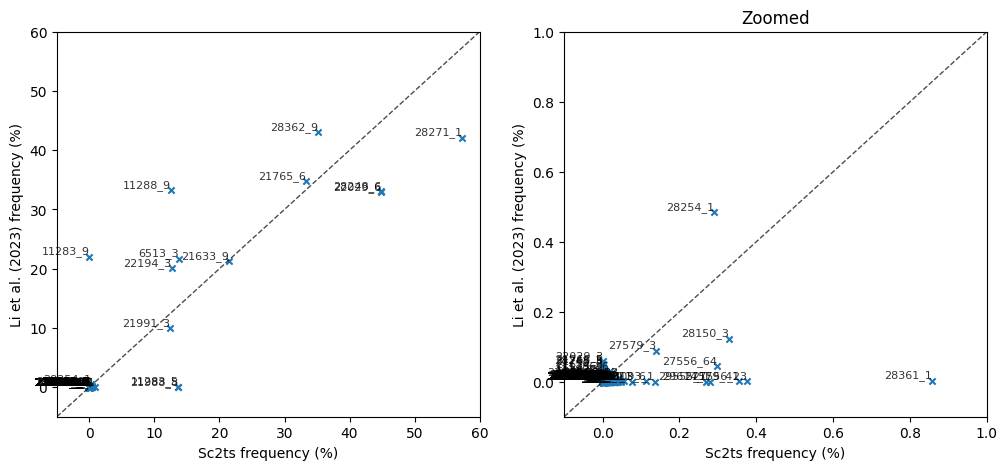

In [14]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].scatter(
    x=agg_dels_df["agg_sc2ts_freq"],
    y=agg_dels_df["li_freq"],
    s=20,
    marker='x',
)
ax[0].set_xlim(-5, 60)
ax[0].set_ylim(-5, 60)
ax[0].set_xlabel("Sc2ts frequency (%)")
ax[0].set_ylabel("Li et al. (2023) frequency (%)")
for i, row in agg_dels_df.iterrows():
    ax[0].text(
        row["agg_sc2ts_freq"],
        row["li_freq"],
        str(row["start"]) + "_" + str(row["length"]),
        fontsize=8,
        alpha=0.8,
        ha='right',
        va='bottom',
    )
ax[0].axline((0, 0), slope=1, color='k', linestyle='--', lw=1, alpha=0.7)


ax[1].set_title("Zoomed")
ax[1].scatter(
    x=agg_dels_df["agg_sc2ts_freq"],
    y=agg_dels_df["li_freq"],
    s=20,
    marker='x',
)
ax[1].set_xlim(-0.1, 1)
ax[1].set_ylim(-0.1, 1)
ax[1].set_xlabel("Sc2ts frequency (%)")
ax[1].set_ylabel("Li et al. (2023) frequency (%)")
for i, row in agg_dels_df.iterrows():
    if row["agg_sc2ts_freq"] > 1.0 or row["li_freq"] > 1.0:
        continue
    ax[1].text(
        row["agg_sc2ts_freq"],
        row["li_freq"],
        str(row["start"]) + "_" + str(row["length"]),
        fontsize=8,
        alpha=0.8,
        ha='right',
        va='bottom',
    )
ax[1].axline((0, 0), slope=1, color='k', linestyle='--', lw=1, alpha=0.7);

In [15]:
common_dels_df = agg_dels_df[
    (agg_dels_df["agg_sc2ts_freq"] >= 1.0) | (agg_dels_df["li_freq"] >= 1.0)
]\
.sort_values(by="agg_sc2ts_freq", ascending=False)\
.reset_index(drop=True)
common_dels_df

,start,length,region,ORF1AB_region,spike_region,max_inheritors,agg_sc2ts_freq,Count,li_freq
0,28271,1,non-coding,,,1422469.0,57.3078,3853692.0,42.1183
1,28248,6,ORF8,,,1114712.0,44.9090,3026186.0,33.0742
2,22029,6,S,,S1-NTD,1114415.0,44.8970,3010665.0,32.9046
3,11288,4,ORF1ab,NSP6,,871838.0,35.1242,NaN,NaN
4,28362,9,N,,,871778.0,35.1218,3939164.0,43.0525
5,21765,6,S,,S1-NTD,825628.0,33.2625,3179887.0,34.7541
6,21633,9,S,,S1-NTD,532084.0,21.4364,1941962.0,21.2244
7,11292,5,ORF1ab,NSP6,,531943.0,21.4307,NaN,NaN
8,6513,3,ORF1ab,NSP3,,341714.0,13.7668,1984683.0,21.6913
9,11283,5,ORF1ab,NSP6,,339935.0,13.6951,8360.0,0.0914


In [16]:
latex_tab_common_dels = r'\begin{table}' + "\n" + \
r'\centering' + "\n" + \
r'\caption{Most commonly observed deletions in the ARG or Li et al. (2023).} ' + "\n" + \
r'\label{tab:common_dels}' + "\n" + \
r'\begin{tabular}{rrcrrrr}' + "\n" + \
r'\toprule' + "\n" + \
r'\multicolumn{3}{c}{} & \multicolumn{2}{c}{Sc2ts ARG} & \multicolumn{2}{c}{Li et al. (2023)} \\' + "\n" + \
r'\cmidrule(lr){4-5} \cmidrule(lr){6-7}' + "\n" + \
r'Start & Length & Region & Count & Frequency (\%) & Count & Frequency (\%) \\' + "\n" + \
r'\midrule' + "\n"

for row in common_dels_df.itertuples():
    region = row.region + " / " + row.ORF1AB_region if row.ORF1AB_region != "" else row.region
    region += " / " + row.spike_region if row.spike_region != "" else ""
    sc2ts_count = "N/A" if np.isnan(row.max_inheritors) else f"{int(row.max_inheritors)}"
    sc2ts_freq = "N/A" if np.isnan(row.agg_sc2ts_freq) else f"{row.agg_sc2ts_freq:.4f}"
    li_count = "N/A" if np.isnan(row.Count) else f"{int(row.Count)}"
    li_freq = "N/A" if np.isnan(row.li_freq) else f"{row.li_freq:.4f}"
    latex_tab_common_dels += f"{row.start} & {row.length} & {region} & " + \
        f"{sc2ts_count} & {sc2ts_freq} & {li_count} & {li_freq}" + r' \\' + "\n"

latex_tab_common_dels += r'\bottomrule' + "\n" + \
r'\end{tabular}' + "\n" + \
r'\end{table}'

print(latex_tab_common_dels)

\begin{table}
\centering
\caption{Most commonly observed deletions in the ARG or Li et al. (2023).} 
\label{tab:common_dels}
\begin{tabular}{rrcrrrr}
\toprule
\multicolumn{3}{c}{} & \multicolumn{2}{c}{Sc2ts ARG} & \multicolumn{2}{c}{Li et al. (2023)} \\
\cmidrule(lr){4-5} \cmidrule(lr){6-7}
Start & Length & Region & Count & Frequency (\%) & Count & Frequency (\%) \\
\midrule
28271 & 1 & non-coding & 1422469 & 57.3078 & 3853692 & 42.1183 \\
28248 & 6 & ORF8 & 1114712 & 44.9090 & 3026186 & 33.0742 \\
22029 & 6 & S / S1-NTD & 1114415 & 44.8970 & 3010665 & 32.9046 \\
11288 & 4 & ORF1ab / NSP6 & 871838 & 35.1242 & N/A & N/A \\
28362 & 9 & N & 871778 & 35.1218 & 3939164 & 43.0525 \\
21765 & 6 & S / S1-NTD & 825628 & 33.2625 & 3179887 & 34.7541 \\
21633 & 9 & S / S1-NTD & 532084 & 21.4364 & 1941962 & 21.2244 \\
11292 & 5 & ORF1ab / NSP6 & 531943 & 21.4307 & N/A & N/A \\
6513 & 3 & ORF1ab / NSP3 & 341714 & 13.7668 & 1984683 & 21.6913 \\
11283 & 5 & ORF1ab / NSP6 & 339935 & 13.6951 & 8360 & 0.0

Table 3: Deletions commonly observed in the Sc2ts ARG and Li et al. (2023). These deletions occur at least 1% of the samples analyzed.

## Examine the alignments for missing deletions

Two deletions from the Li et al. data are missing from sc2ts. Is this because we're not handling them correctly in the input or because they're not present in the alignments? 



In [17]:
import sc2ts

ds = sc2ts.Dataset("../data/viridian_mafft_2024-10-14_v1.vcz.zip")

In [43]:

def allele_composition(ds, start, stop):
    data = []
    for var in ds.variants(position=np.arange(start, stop)):
        # IMPORTANT: -1 encodes missing data, which is not explicitly listed in the alleles array.
        # Append "N" to the end to ensure that -1 will be mapped to N.
        alleles = np.append(var.alleles, ["N"])
        counter = collections.Counter(alleles[var.genotypes])
        data.append({"position": int(var.position), **{a:counter[a] for a in alleles}})
    return pd.DataFrame(data, dtype=int)


In [57]:
# Get the set of sites that we remapped using parsimony
remapped_sites = np.loadtxt("../arg_postprocessing/remapped_sites.txt").astype(int)
len(remapped_sites)

236

### 686+9 deletion
Get the allele composition in the immediate surroundings of the deletion to see if there's anything funny going on.

In [62]:
df = allele_composition(ds, 680, 700).set_index("position")
df

,A,C,G,T,-,R,Y,S,W,K,M,B,D,H,V,.,N
position,,,,,,,,,,,,,,,,,
680,1014,2,4478460,67,1172,64,0,0,0,9,0,0,0,0,0,0,3369
681,4479143,167,296,11,1169,15,0,0,0,0,8,0,0,0,0,0,3348
682,5,1049,182,4478339,1203,0,44,0,0,2,0,0,0,0,0,0,3333
683,75,4469044,6,9864,1201,0,597,3,0,0,7,0,0,0,0,0,3360
684,1,121,1,4479241,1411,0,11,0,1,1,0,0,0,0,0,0,3369
685,4479044,0,310,12,1453,4,0,0,1,0,0,0,0,0,0,0,3333
686,4402691,20,168,0,77798,5,0,0,0,0,1,0,0,0,0,0,3474
687,4402285,249,230,91,77806,20,0,0,2,0,2,0,0,0,0,0,3472
688,598,28,4396242,491,77806,19,0,0,0,12,0,0,0,0,0,0,8961


In [63]:
df = df.loc[np.arange(686,  686 + 9)]
df

,A,C,G,T,-,R,Y,S,W,K,M,B,D,H,V,.,N
position,,,,,,,,,,,,,,,,,
686,4402691,20,168,0,77798,5,0,0,0,0,1,0,0,0,0,0,3474
687,4402285,249,230,91,77806,20,0,0,2,0,2,0,0,0,0,0,3472
688,598,28,4396242,491,77806,19,0,0,0,12,0,0,0,0,0,0,8961
689,28,334,89,4399958,77818,0,22,0,2,1,0,0,0,0,0,0,5905
690,9,4399947,76,566,77807,0,30,6,0,0,0,0,0,0,0,0,5716
691,4396134,25,1906,2830,77771,24,0,0,4,0,4,0,0,0,0,0,5459
692,47,1201,93,4401309,77812,0,14,0,1,0,0,0,0,0,0,0,3680
693,51,90,58,4402865,77703,0,6,0,2,3,0,0,0,0,0,0,3379
694,424,453,53,4402048,77667,0,23,0,14,3,0,0,0,0,0,0,3472


In [64]:
len(set(remapped_sites) & set(df.index))

0

For the 686+9 deletion, we do indeed have a high frequency deletion in the alignments which aligns exactly. But, these sites were not included in the sites that we remapped so we don't see it in the ARG.

### 21987+9 deletion

In [65]:
df = allele_composition(ds, 21980, 22000).set_index("position")
df

,A,C,G,T,-,R,Y,S,W,K,M,B,D,H,V,.,N
position,,,,,,,,,,,,,,,,,
21980,114,141,12,3924590,1795,0,19,0,9,2,0,0,0,0,0,0,557475
21981,2,38,1,3924169,2260,0,14,0,4,3,0,0,0,0,0,0,557666
21982,7,47,3,3924015,2351,0,15,0,2,2,0,0,0,0,0,0,557715
21983,9,35,27,3921734,2138,0,8,0,3,0,0,0,0,0,0,0,560203
21984,0,20,32,3920015,2024,0,16,0,1,3,0,0,0,0,0,0,562046
21985,169,9,3919641,1025,2361,11,0,3,0,128,0,0,0,0,0,0,560810
21986,472,17,3919841,127,2390,27,0,4,0,23,0,0,0,0,0,0,561256
21987,2281727,48,734874,1772,771917,126197,0,5,2,80,2,0,0,0,0,0,567533
21988,10,319,6,3144705,773060,0,9,0,1,0,0,0,0,0,0,0,566047


In [66]:
df = df.loc[np.arange(21987,  21987 + 9)]
df

,A,C,G,T,-,R,Y,S,W,K,M,B,D,H,V,.,N
position,,,,,,,,,,,,,,,,,
21987,2281727,48,734874,1772,771917,126197,0,5,2,80,2,0,0,0,0,0,567533
21988,10,319,6,3144705,773060,0,9,0,1,0,0,0,0,0,0,0,566047
21989,166,106,3144560,678,772988,4,0,2,0,52,0,0,0,0,0,0,565601
21990,85,73,2,3141850,773193,0,8,0,2,6,0,0,0,0,0,0,568938
21991,2,124,4,2972798,1343891,0,5,0,0,15,0,0,0,0,0,0,167318
21992,106,56,40,2973149,1343997,0,16,0,1,0,0,0,0,0,0,0,166792
21993,2969287,2246,9,868,1344711,23,2,0,10,0,2,0,0,0,0,0,166999
21994,86,1254,63,3549832,771590,0,25,0,43,0,1,0,0,0,0,0,161263
21995,2384,122866,438,3424155,772727,0,77,1,9,9,5,0,0,0,0,0,161486


In [67]:
len(set(remapped_sites) & set(df.index))

8

In [69]:
sorted(list(set(remapped_sites) & set(df.index)))

[21988, 21989, 21990, 21991, 21992, 21993, 21994, 21995]

This one is not so straightforward, and looks like there may be an overlapping three base deletion at 21990.

Here, we're missing one of the sites from the deletion (21987). This is a complicated region though, as it looks like there's 3 overlapping deletions - 21987+9, 21988+8 and 21991+3. Given the large number of "R" (A or G) uncertainty values for 21987, this all looks a bit quirky?


In [71]:
major_events_df[major_events_df.start == 21988]

,start,node,length,max_inheritors,min_inheritors,region,ORF1AB_region,spike_region,pango,deletion,sc2ts_freq
10,21988,851246,8,339651,339385,S,,S1-NTD,BA.1,"(21988, 21989, 21990, 21991, 21992, 21993, 219...",13.6837


In [72]:
major_events_df[major_events_df.start.isin(df.index)]

,start,node,length,max_inheritors,min_inheritors,region,ORF1AB_region,spike_region,pango,deletion,sc2ts_freq
10,21988,851246,8,339651,339385,S,,S1-NTD,BA.1,"(21988, 21989, 21990, 21991, 21992, 21993, 219...",13.6837
14,21991,86456,3,288831,288192,S,,S1-NTD,B.1.1.7,"(21991, 21992, 21993)",11.6363
